# SEIRS+ Network Model Demo

**This notebook provides a demonstration of the core functionality of the SEIRS+ Network Model and offers a sandbox for easily changing simulation parameters and scenarios.** 
For a more thorough walkthrough of the model and use of this package, refer to the README.

### Installing and Importing the model code
All of the code needed to run the model is imported from the ```models``` module of this package.

#### Install the package using ```pip```
The package can be installed on your machine by entering this in the command line:

```sudo pip install seirsplus```

Then, the ```models``` module can be imported into your scripts as shown here:

In [1]:
from seirsplus.models import *
import networkx

#### *Alternatively, manually copy the code to your machine*
*You can use the model code without installing a package by copying the ```models.py``` module file to a directory on your machine. In this case, the easiest way to use the module is to place your scripts in the same directory as the module, and import the module as shown here:*
```python
from models import *
```

In [1]:
import networkx

ModuleNotFoundError: No module named 'networkx'

### Generating interaction networks

This model simulates SEIRS epidemic dynamics for populations with a structured interaction network (as opposed to standard deterministic SIR/SEIR/SEIRS models, which assume uniform mixing of the population). As such, a graph specifying the interaction network for the population must be specified, where each node represents an individual in the population and edges connect individuals who have regular interactions.

The interaction network can be specified by a ```networkx``` Graph object or a 2D numpy array representing the adjacency matrix, either of which can be defined and generated by any method.

*Here, we use a ```custom_exponential_graph()``` generation function included in this package, which generates power-law graphs that have degree distributions with two exponential tails. For more information on this custom graph type and its generation, see the README.*

**_Note:_** *Simulation time increases with network size. Small networks simulate quickly, but have more stochastic volatility. Networks with ~10,000 are large enough to produce per-capita population dynamics that are generally consistent with those of larger networks, but small enough to simulate quickly. We recommend using networks with ~10,000 nodes for prototyping parameters and scenarios, which can then be run on larger networks if more precision is required (for more on this, see README).*

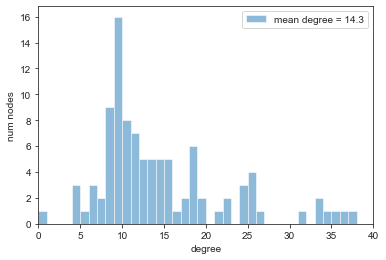

In [4]:
numNodes = 100
baseGraph    = networkx.barabasi_albert_graph(n=numNodes, m=9)
# Baseline normal interactions:
G_normal     = custom_exponential_graph(baseGraph, scale=100)
plot_degree_distn(G_normal, max_degree=40)

Epidemic scenarios of interest often involve interaction networks that change in time. Multiple interaction networks can be defined and used at different times in the model simulation, as will be shown below.

*Here we generate a graph representing interactions during corresponding to Social Distancing, where each individual drops some portion of their normal interactions with others. Again, we use the ```custom_exponential_graph()``` to generate this graph; for more information, see the README.*

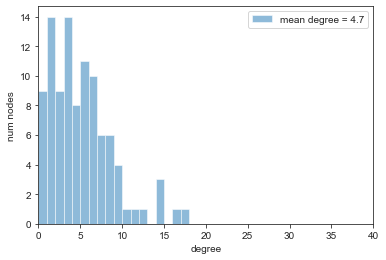

In [5]:
# Social distancing interactions:
G_distancing = custom_exponential_graph(baseGraph, scale=10)
plot_degree_distn(G_distancing, max_degree=40)

This SEIRS+ model features dynamics corresponding to testing individuals for the disease and moving individuals with detected infection into a state where their rate of recovery, mortality, etc may be different. In addition, given that this model considers individuals in an interaction network, a separate graph defining the interactions for individuals with detected cases can be specified.

*Here we generate a graph representing the interactions that individuals have when they test positive for the disease. In this case, a significant portion of each individual's normal interaction edges are removed from the graph, as if the individual is quarantined upon detection of infection. Again, we use the ```custom_exponential_graph()``` to generate this graph; for more information, see the README.*

For more information on how testing, contact tracing, and detected cases are handled in this model, see the README.

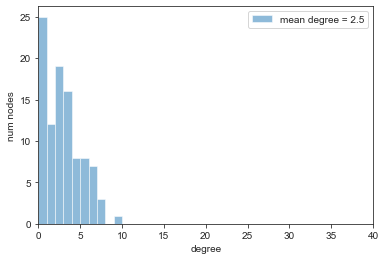

In [6]:
# Quarantine interactions:
G_quarantine = custom_exponential_graph(baseGraph, scale=5)
plot_degree_distn(G_quarantine, max_degree=40)

### Initializing the model parameters
All model parameter values, including the normal and quarantine interaction networks, are set in the call to the ```SEIRSNetworkModel``` constructor. The normal interaction network ```G``` and the basic SEIR parameters ```beta```, ```sigma```, and ```gamma``` are the only required arguments. All other arguments represent parameters for optional extended model dynamics; these optional parameters take default values that turn off their corresponding dynamics when not provided in the constructor. For clarity and ease of customization in this notebook, all available model parameters are listed below. 

For more information on parameter meanings, see the README.

*The parameter values shown correspond to rough estimates of parameter values for the COVID-19 epidemic.*

In [7]:
model = SEIRSNetworkModel(G       =G_normal, 
                          beta    =0.155, 
                          sigma   =1/5.2, 
                          gamma   =1/12.39, 
                          mu_I    =0.0004,
                          mu_0    =0, 
                          nu      =0, 
                          xi      =0,
                          p       =0.5,
                          Q       =G_quarantine, 
                          beta_D  =0.155, 
                          sigma_D =1/5.2, 
                          gamma_D =1/12.39, 
                          mu_D    =0.0004,
                          theta_E =0, 
                          theta_I =0, 
                          phi_E   =0, 
                          phi_I   =0, 
                          psi_E   =1.0, 
                          psi_I   =1.0,
                          q       =0.5,
                          initI   =numNodes/100, 
                          initE   =0, 
                          initD_E =0, 
                          initD_I =0, 
                          initR   =0, 
                          initF   =0)

### Checkpoints
Model parameters can be easily changed during a simulation run using checkpoints. A dictionary holds a list of checkpoint times (```checkpoints['t']```) and lists of new values to assign to various model parameters at each checkpoint time. Any model parameter listed in the model constrcutor can be updated in this way. Only model parameters that are included in the checkpoints dictionary have their values updated at the checkpoint times, all other parameters keep their pre-existing values.

*The checkpoints shown here correspond to starting social distancing and testing at time ```t=20``` (the graph ```G``` is updated to ```G_distancing``` and locality parameter ```p``` is decreased to ```0.1```; testing params ```theta_E```, ```theta_I```, ```phi```, and ```phi_I``` are set to non-zero values) and then stopping social distancing at time ```t=100``` (```G``` and ```p``` changed back to their "normal" values; testing params remain non-zero).*

In [8]:
checkpoints = {'t':       [20, 100], 
               'G':       [G_distancing, G_normal], 
               'p':       [0.1, 0.5], 
               'theta_E': [0.02, 0.02], 
               'theta_I': [0.02, 0.02], 
               'phi_E':   [0.2, 0.2], 
               'phi_I':   [0.2, 0.2]}

### Running the simulation

In [9]:
model.run(T=300, checkpoints=checkpoints)

t = 10.50
[Checkpoint: Updating parameters]
t = 20.30
t = 40.10
t = 50.26
t = 60.06
t = 70.14
t = 80.13
t = 90.06
[Checkpoint: Updating parameters]
t = 110.87


True

### Visualizing the results
The ```SEIRSNetworkModel``` class has a ```plot()``` convenience function for plotting simulation results on a matplotlib axis. This function generates a line plot of the frequency of each model state in the population by default, but there are many optional arguments that can be used to customize the plot.

The ```SEIRSNetworkModel``` class also has convenience functions for generating a full figure out of model simulation results (optionaly arguments can be provided to customize the plots generated by these functions). 
- ```figure_basic()``` calls the ```plot()``` function with default parameters to generate a line plot of the frequency of each state in the population.
- ```figure_infections()``` calls the ```plot()``` function with default parameters to generate a stacked area plot of the frequency of only the infection states ($E$, $I$, $D_E$, $D_I$) in the population.

For more information on the built-in plotting functions, see the README.

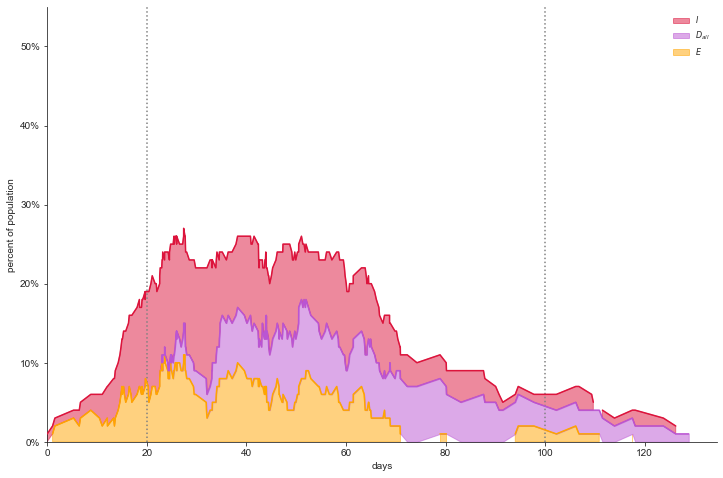

(<Figure size 864x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x125b29130>)

In [11]:
model.figure_infections(vlines=checkpoints['t'], ylim=0.55)

#### Reference simulation visualizations

We can also visualize the results of other simulation(s) as a reference for comparison of our main simulation.

Here we simulate a model where no distancing or testing takes place, so that we can compare the effects of these interventions:

In [12]:
ref_model = SEIRSNetworkModel(G=G_normal, beta=0.155, sigma=1/5.2, gamma=1/12.39, mu_I=0.0004, p=0.5,
                          Q=G_quarantine, beta_D=0.155, sigma_D=1/5.2, gamma_D=1/12.39, mu_D=0.0004,
                          theta_E=0, theta_I=0, phi_E=0, phi_I=0, psi_E=1.0, psi_I=1.0, q=0.5,
                          initI=numNodes/100)
ref_model.run(T=300)

True

Now we can visualize our main simulation together with this reference simulation by passing the model object of the reference simulation to the appropriate figure function argument (note: a second reference simulation could also be visualized by passing it to the ```dashed_reference_results``` argument):

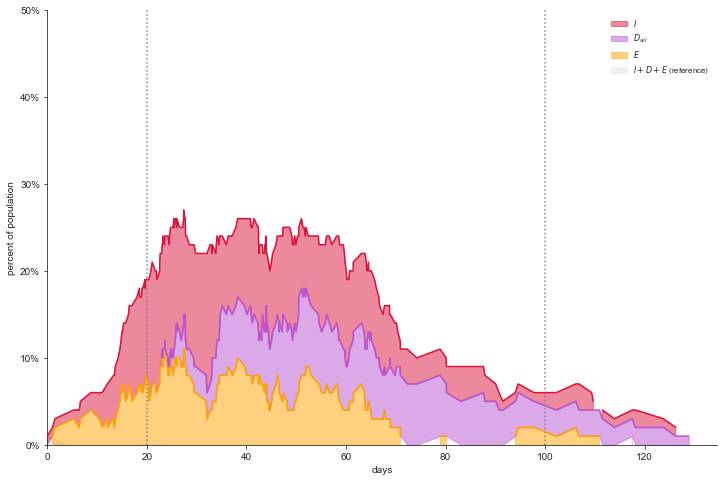

(<Figure size 864x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1260fc160>)

In [14]:
model.figure_infections(vlines=checkpoints['t'], ylim=0.5, shaded_reference_results=ref_model)

As further demonstration, we might also wish to compare the results of these network model simulations to a deterministic model simulation of the same SEIRS parameters (with no interventions in this case):

In [15]:
ref_model_determ = SEIRSModel(beta=0.147, sigma=1/5.2, gamma=1/12.39, mu_I=0.0004, initI=100, initN=10000) 
ref_model_determ.run(T=300)

t = 299.90


True

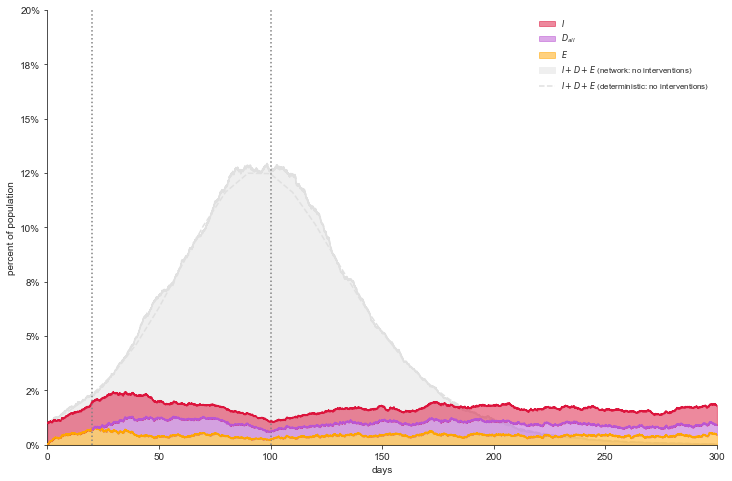

In [12]:
model.figure_infections(vlines=checkpoints['t'], ylim=0.2, 
                        shaded_reference_results=ref_model, shaded_reference_label='network: no interventions',
                        dashed_reference_results=ref_model_determ, dashed_reference_label='deterministic: no interventions')